In [83]:
import torch

from detr.data import CocoDataset, get_val_transforms, get_collate_function
from detr.model import DETRConfig, DETR
from detr.position_encoding import PositionalEncoding

from detr.matcher import HungarianMatcher
from detr.loss import SetCriterion

from safetensors.torch import load_model

from detr.visualize import plot, plot_grid
from detr.utils import PostProcess, DetectionMetrics

from PIL import Image

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
val_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "train",
    transform = get_val_transforms()
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0,
    collate_fn=get_collate_function(),
)
device = "cuda"

config = DETRConfig(
    num_classes = val_dataset.num_classes
)
model = DETR(config).to(device)
weights_fpath = "/media/bryan/ssd01/expr/detr_from_scratch/debug01/checkpoints/checkpoint_99/model.safetensors"
load_model(model, weights_fpath, device = device)

torch.cuda.empty_cache()

loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [4]:
batch = next(iter(val_dataloader))
batch.keys()

dict_keys(['image', 'height', 'width', 'image_id', 'boxes', 'class_idx', 'class_id', 'iscrowd', 'boxes_normalized'])

In [5]:
device = "cuda"
for key in batch:
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].to(device)
    elif isinstance(batch[key], list):
        if isinstance(batch[key][0], torch.Tensor):
            batch[key] = [x.to(device) for x in batch[key]]

In [6]:
outputs = model(batch["image"], batch["height"], batch["width"])

In [7]:
outputs.keys()

dict_keys(['pred_logits', 'pred_boxes'])

In [8]:
batch.keys()

dict_keys(['image', 'height', 'width', 'image_id', 'boxes', 'class_idx', 'class_id', 'iscrowd', 'boxes_normalized'])

In [9]:
matcher = HungarianMatcher(cost_class = 1, cost_bbox = 5, cost_giou = 2)
criterion = SetCriterion(val_dataset.num_classes, matcher).to(device)

In [14]:
losses = criterion(outputs, batch)

In [15]:
loss = sum(losses[k] for k in losses.keys() if k.startswith("loss"))

In [84]:
results = PostProcess(val_dataloader.dataset.class_names)(
    outputs["pred_logits"][:,-1].cpu(),
    outputs["pred_boxes"][:,-1].cpu(),
    batch["height"].cpu(),
    batch["width"].cpu()
)

In [87]:
device = "cpu"
for key in batch:
    if isinstance(batch[key], torch.Tensor):
        batch[key] = batch[key].to(device)
    elif isinstance(batch[key], list):
        if isinstance(batch[key][0], torch.Tensor):
            batch[key] = [x.to(device) for x in batch[key]]

In [88]:
metrics = DetectionMetrics(val_dataloader.dataset.class_names)

In [89]:
metrics.update(results, batch)

In [90]:
val_metrics = metrics.compute()

In [91]:
val_metrics

{'AP': 0.0,
 'AP50': 0.0,
 'AP75': 0.0,
 'AP-large': 0.0,
 'AP-medium': 0.0,
 'AP-small': 0.0,
 'AP-per-class/person': 0.0,
 'AP-per-class/bicycle': 0.0,
 'AP-per-class/car': 0.0,
 'AP-per-class/motorcycle': 0.0,
 'AP-per-class/airplane': 0.0,
 'AP-per-class/bus': 0.0,
 'AP-per-class/train': 0.0,
 'AP-per-class/truck': 0.0,
 'AP-per-class/boat': 0.0,
 'AP-per-class/traffic light': 0.0,
 'AP-per-class/fire hydrant': 0.0,
 'AP-per-class/stop sign': 0.0,
 'AP-per-class/parking meter': 0.0,
 'AP-per-class/bench': 0.0,
 'AP-per-class/bird': 0.0,
 'AP-per-class/cat': 0.0,
 'AP-per-class/dog': 0.0,
 'AP-per-class/horse': 0.0,
 'AP-per-class/sheep': 0.0,
 'AP-per-class/cow': 0.0,
 'AP-per-class/elephant': 0.0,
 'AP-per-class/bear': 0.0,
 'AP-per-class/zebra': 0.0,
 'AP-per-class/giraffe': 0.0,
 'AP-per-class/backpack': 0.0,
 'AP-per-class/umbrella': 0.0,
 'AP-per-class/handbag': 0.0,
 'AP-per-class/tie': 0.0,
 'AP-per-class/suitcase': 0.0,
 'AP-per-class/frisbee': 0.0,
 'AP-per-class/skis': 0.

In [92]:
preds = results
batch_flat = []
for i in range(batch["image"].shape[0]):
    item = {k: v[i] for k, v in batch.items()}
    item["class_names"] = [
        val_dataloader.dataset.class_names[c] for c in item["class_idx"].tolist()
    ]
    batch_flat.append(item)
    preds[i]["image"] = batch["image"][i]

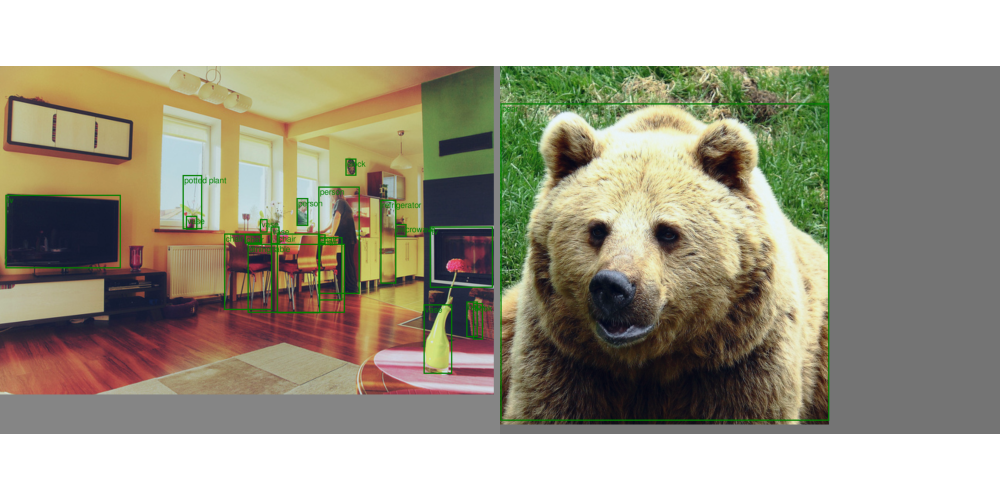

In [95]:
vis_gt = plot_grid(
    batch_flat,
    max_images=25,
    num_cols=5,
    font_size=20,
    box_color="green",
    fig_scaling=5,
)
Image.fromarray(vis_gt)

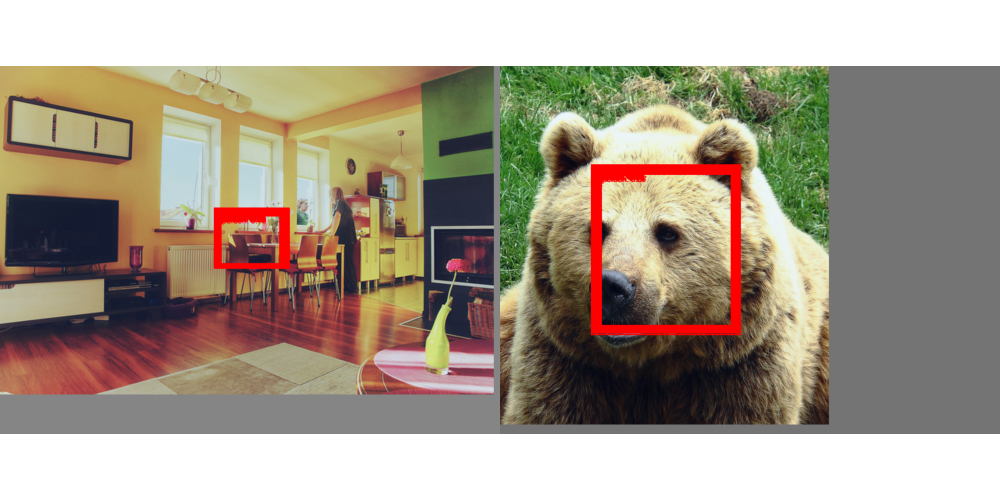

In [96]:
vis_preds = plot_grid(
    preds,
    max_images=25,
    num_cols=5,
    font_size=20,
    box_color="red",
    fig_scaling=5,
)
Image.fromarray(vis_preds)